# Projet Groupe 5 - Enclos


### 1 - Étude du problème d'optimisation

**1.** On a : $y_0$ et $y_{N}$ qui sont fixés à $0$. Remarquons de plus que, les $d_i$ étant données, on connaît les $x_i$, et par conséquent, avec la donnée de $y_i$ et $y_{i+1}$, on peut déterminer $\theta_i$.

On en déduit que $z$ possède $N - 1$ composantes.

Ensuite, on remarque que si l'on approxime la section d'aire comprise entre $x_i$ et $x_{i+1}$ par un rectangle surmonté du triangle $(x_i,y_i),(x_{i+1},y_i),(x_{i+1}y_{i+1})$, l'aire de cette section se ramène à 
$$
\begin{split}
\mathcal{A}_i 
& = y_id_i + \frac{1}{2}d_i(y_i+y_{i+1}) \\
& = \frac{1}{2}d_i(y_i + y_{i+1})
\end{split}
$$

D'où : 
$$
\begin{split}
\mathcal{A} 
& = \sum^{N-1}_{i=0}{\mathcal{A}_i} \\
& = \sum^{N-1}_{i=0}{\frac{1}{2}d_i(y_i + y_{i+1})} \\
& = \sum^{N-1}_{i=0}{\frac{1}{2}d_i(y_i)} + \sum^{N-1}_{i=0}{\frac{1}{2}d_i(y_{i+1})} \\
& = \frac{1}{2}d_0y_0 + \sum^{N-1}_{i=1}{\frac{1}{2}d_i(y_i)} + \sum^{N-1}_{i=1}{\frac{1}{2}d_{i-1}(y_{i})} \\
& = \sum^{N-1}_{i=1}{\frac{d_i + d_{i+1}}{2}y_i}
\end{split}
$$

On pose donc :

$\boxed{
z = (y_1, ...,y_{N-1}) \text{ et }
c = -(\frac{d_0 + d_{1}}{2},...,\frac{d_{N-1} + d_{N}}{2})}
$

(le $-$ devant le c vient du fait que l'on veut se ramener à un problème de minimisation)

**2.** La contrainte égalité associée est que la somme des hypothénuses $h_i$ des triangles doit valoir la longueur de la corde L.

On a pour un triangle : $$h_i = \sqrt{d_i^2 + (y_{i+1} - y_i)^2}$$

Donc, on pose :

$$\boxed{g(z) = \sum_{i=0}^{N-1}{\sqrt{d_i^2 + (y_{i+1} - y_i)^2}} -L}$$

**3.** Déjà, $g$ est $\mathcal{C}^{\infty}$ par somme de fonctions elles-mêmes $\mathcal{C}^{\infty}$ par composition.

De surcroît, on remarque que la hessienne de $g_i : (x,y) \mapsto \sqrt{d_i^2 + (x - y)^2}$ est :

$$H_g = \frac{d_i}{(d_i^2 + (x - y)^2)^{\frac{3}{2}}} 
\begin{pmatrix}
1 & -1\\
-1 & 1
\end{pmatrix}
$$

Les valeurs propres de la matrice $\begin{pmatrix}
1 & -1\\
-1 & 1
\end{pmatrix}$ sont 0, associée au vecteur propre $\begin{pmatrix}
1\\
1
\end{pmatrix}$ et 2, associé à $\begin{pmatrix}
-1\\
1
\end{pmatrix}$, elle est donc positive, donc $g_i$ est convexe, et donc $g$ est convexe comme somme de fonctions convexes.

### 2 - Résolution numérique

Pour `init_guess`, s'il n'est pas donné, on veut trouver une position de la corde qui respecte la contrainte. Pour cela, on va choisir de mettre à plat les $3^e$ à $(N+1)^e$  points, et de créer un "pic" au niveau du point $1$.

Il faut donc calculer sa hauteur. On sait, si on note $\alpha$ l'hypothénuse du premier triangle, et $\beta$ celle du second, qu'au total, 
$$
L = (b-a-d_0-d_1) + \alpha + \beta
$$

Si on remplace $\alpha$ et $\beta$ par leurs valeurs, on obtient :
$$
L = (b-a-d_0-d_1) + \sqrt{d_0^2 + y^2} + \sqrt{d_1^2 + y^2}
$$

On doit donc résoudre l'équation $f(y) = 0$, où $f:y \mapsto (b-a-d_0-d_1) + \sqrt{d_0^2 + y^2} + \sqrt{d_1^2 + y^2} - L$, ce que l'on peut faire numériquement avec la fonction `scipy.optimize.fsolve`

In [41]:
import scipy.optimize as opt
import numpy as np

def optimal_curve (a , b , L , N =40 , d = None , init_guess = None ):
    
    if not d : d = [(b-a)/N for _ in range(N)]

    if not init_guess:
        def f(y):
            return (b-a-d[0]-d[1] + np.sqrt(d[0]**2 + y**2) + np.sqrt(d[1]**2 + y**2) - L)
        y_1_init = opt.fsolve(f, L/2)
        init_guess = np.append(y_1_init, [0 for _ in range(N-2)])

    #Fonction des contraintes
    def g(z):
        tot = np.sqrt(d[0]**2 + z[0]**2) #Car le terme y_0 intervient dans g, mais n'est pas contenu dans z. On le traite donc a part
        for i in range(N-2):
            tot += np.sqrt(d[i]**2 + (z[i+1] - z[i])**2)
        tot += np.sqrt(d[N-1]**2 + z[-1]**2) #Idem pour le terme y_N
        return tot - L
    
    #Vecteur tel que <c,z> soit ce que l'on veut minimiser
    c = np.array([-(d[k]+d[k+1])/2 for k in range(N-1)]) 
    
    #Fonction a minimiser
    def a_minimiser(z):
        return np.dot(z,c)


    #Resolution du probleme
    x_opt = [a]
    for k in range(N):
        x_opt.append(x_opt[-1]+d[k])
    x_opt = np.array(x_opt)
    
    y_opt = np.append(np.append([0], opt.minimize(a_minimiser, init_guess, constraints={'type' : 'eq', 'fun' : g}).x), [0])
    t_opt = [(y_opt[k+1]-y_opt[k])/d[k] for k in range(N)]

    return x_opt , y_opt , t_opt

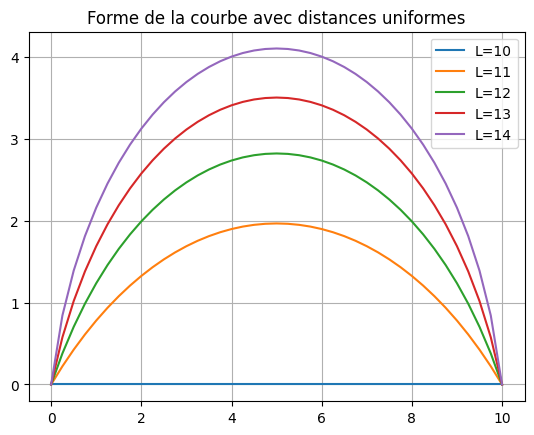

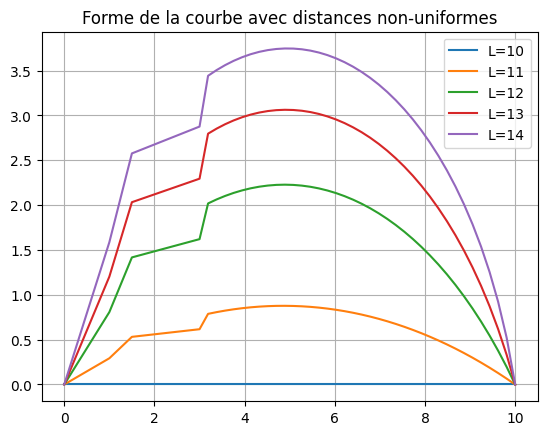

In [ ]:
import matplotlib.pyplot as plt

a = 0
b = 10

d = [1,1/2,3/2] + [7/37]*37 #Exemple de distribution de distances non-uniforme

for k in range(5):
    L = b-a + k

    x,y,t = optimal_curve(a,b,L)

    plt.plot(x,y, label = ("L="+str(L)))

plt.legend()
plt.grid()
plt.title("Forme de la courbe avec distances uniformes")
plt.show()

for k in range(5):
    L = b-a + k

    x,y,t = optimal_curve(a,b,L,d=d)

    plt.plot(x,y, label = ("L="+str(L)))

plt.legend()
plt.grid()
plt.title("Forme de la courbe avec distances non-uniformes")
plt.show()

On remarque que la forme optimale semble être une parabole dans le cas d'une distribution uniforme des abscisses de la clôture, mais semble prendre des formes moins prédictibles dans le cas où les abscisses sont réparties différemment.

Ainsi, cette condition semble être réalisée dès que $L>b-a$ (autrement la courbe est parfaitement plate, ce qui ne peut correspondre à aucun polynôme) et que la distribution des distances est uniforme.

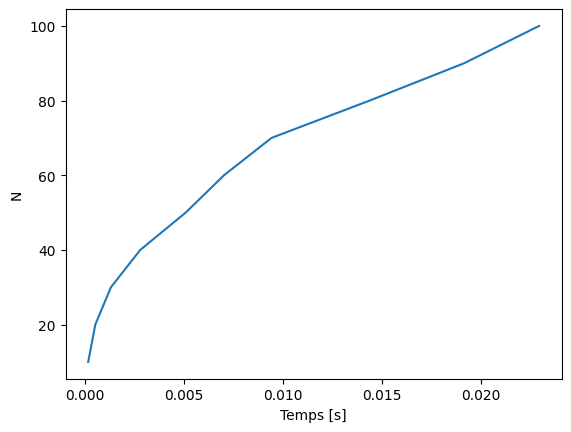

In [59]:
import time as time

a = 0
b = 1
L = 1.25

T = np.zeros(10)
N = [10 + k*10 for k in range(10)]

for n in N:
    for _ in range(10):
        start = time.time()
        optimal_curve(a,b,L,N=n)
        T[n//10 - 1] += (time.time() - start)/1000

plt.plot(T,N)
plt.xlabel("Temps [s]")
plt.ylabel("N")
plt.show()